### Responsible Data Science Course Project: Nutritional Labels for Automated Decision Systems

Rohan Mahadev - rm5310, Anindya Chakravarti - ac8184

In [19]:
import os
import yaml
import pickle
import argparse

import numpy as np
import torch
torch.backends.cudnn.benchmark=True
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from PIL import Image

from datasets import LabeledImages
from models.se_resnet import se_resnet101
# Helper functions to draw predictions:

import torchvision.transforms as T

import pandas as pd

from lime import lime_image

from skimage.segmentation import mark_boundaries

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
CONFIG_PATH = './config.yaml'

# ADS being evaluated

In [157]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.n_classes = n_classes
        self.features = se_resnet101()
        self.classifier = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class ModelWithLoss(nn.Module):
    def __init__(self, classifier):
        super(ModelWithLoss, self).__init__()
        self.classifier = classifier
        self.criterion = nn.CrossEntropyLoss(size_average=False)

    def forward(self, x, labels):
        assert len(x) == len(labels)

        predictions = self.classifier(x)

        all_classes = np.arange(self.classifier.n_classes, dtype=np.int64)
        zero_label = torch.tensor([0]).to(x.device)

        loss = 0
        denominator = 0
        for prediction, positives in zip(predictions, labels):
            negatives = np.setdiff1d(all_classes, positives, assume_unique=True)
            negatives_tensor = torch.tensor(negatives).to(x.device)
            positives_tensor = torch.tensor(positives).to(x.device).unsqueeze(dim=1)

            for positive in positives_tensor:
                indices = torch.cat((positive, negatives_tensor))
                loss = loss + self.criterion(prediction[indices].unsqueeze(dim=0), zero_label)
                denominator += 1

        loss /= denominator

        return loss

    def predict(self, x):
        input_shape = x.shape
        if len(input_shape) == 5:
            x = x.view(-1, input_shape[2], input_shape[3], input_shape[4])
            predictions = self.classifier(x)
            predictions = predictions.view(input_shape[0], input_shape[1], -1).mean(dim=1)
        else:
            predictions = self.classifier(x)

        return predictions

In [158]:
with open(CONFIG_PATH, 'r') as f:
    config = yaml.load(f)

In [159]:
dataset_root = config['DATASET']['STAGE2_TEST_IMAGES_ROOT']

In [160]:
assert os.path.exists(dataset_root), dataset_root
sample_submission_path = config['DATASET']['STAGE{}_SAMPLE_SUBMISSION_PATH'.format(2)]
assert os.path.exists(sample_submission_path), sample_submission_path

output_root = config['SUBMISSION']['OUTPUT_ROOT']
assert os.path.exists(output_root), output_root

test_list_path = os.path.join(output_root, 'test_stage{}.txt'.format(2))

In [161]:
with open(config['DATASET']['NAME_TO_LABEL_PATH'], 'rb') as f:
    name_to_label = pickle.load(f)
label_to_name = {label: name for name, label in name_to_label.items()}
n_classes = len(name_to_label)

In [162]:
classifier = Classifier(n_classes)
model = ModelWithLoss(classifier).to(device).eval()

/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [163]:
snapshot_path = os.path.join(config['TUNING']['ARTIFACTS_ROOT'], 'snapshots',
                                 'snapshot_epoch_{}.pth.tar'.format(config['TUNING']['N_EPOCH']))
state = torch.load(snapshot_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state['model'])

<All keys matched successfully>

In [164]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = T.Compose([T.ToTensor(), normalize])

In [165]:
description = pd.read_csv('../../class-descriptions2.csv')
label_lookup = {label: descr for label, descr in zip(description.label_code.values, description.description.values)}

In [206]:
def run_pred(path):    
    img = get_image(path)
    transform = T.Compose([T.Resize(256),T.CenterCrop(224),
                           to_tensor])
    img1 = transform(img)
    img1 = img1.unsqueeze(0)

    with torch.no_grad():
        pred_scores = model.predict(img1.to(device))
        return pred_scores

In [233]:
def detailed_preds(path):
    probs = run_pred(path)
    scores, labels = probs.sort(dim=1, descending=True)
    names = [label_lookup[label_to_name[label.item()]] for label in labels[0]]
    print(labels, names)
    return names

get label numbers of man,boy,girl,woman

tensor([[  15,   89,   58,  ..., 4147, 1990, 9982]]) ['Person', 'Human face', 'Girl', 'Boy', 'Toddler', 'Human hair', 'Hairstyle', 'Smile', 'Human eye', 'Human ear', 'Human nose', 'Human head', 'Crop', 'Beauty', 'Chin', 'Baby', 'Human mouth', 'Portrait photography', 'Neck', 'Portrait', 'Clothing', 'Eyebrow', 'Forehead', 'Eyelash', 'Pageboy', 'Fashion accessory', 'Skin', 'Bowl cut', 'Pixie cut', 'Earrings', 'Child model', 'Child', 'Drawing', 'Human body', 'Bun', 'Jaw', 'Bob cut', 'Cheek', 'Chignon', 'Lip', 'Woman', 'Wings', 'Human arm', 'Close-up', 'Makeover', 'Black', 'White', 'Bangs', 'Mammal', 'Headpiece', 'Black hair', 'Cosmetic dentistry', 'Caesar cut', 'Organ', 'Surfer hair', 'Croydon facelift', 'Photo shoot', 'Photograph', 'Iris', 'Blond', 'Human', 'Human hand', 'Crew cut', 'Curtained hair', 'Beach', 'Body piercing', 'Headband', 'Brown hair', 'Throat', 'Step cutting', 'Happy', 'Necklace', 'Eye liner', 'Style', 'Model', 'Headgear', 'Dress', 'Female person', 'Personal grooming', 'T

['Person',
 'Human face',
 'Girl',
 'Boy',
 'Toddler',
 'Human hair',
 'Hairstyle',
 'Smile',
 'Human eye',
 'Human ear',
 'Human nose',
 'Human head',
 'Crop',
 'Beauty',
 'Chin',
 'Baby',
 'Human mouth',
 'Portrait photography',
 'Neck',
 'Portrait',
 'Clothing',
 'Eyebrow',
 'Forehead',
 'Eyelash',
 'Pageboy',
 'Fashion accessory',
 'Skin',
 'Bowl cut',
 'Pixie cut',
 'Earrings',
 'Child model',
 'Child',
 'Drawing',
 'Human body',
 'Bun',
 'Jaw',
 'Bob cut',
 'Cheek',
 'Chignon',
 'Lip',
 'Woman',
 'Wings',
 'Human arm',
 'Close-up',
 'Makeover',
 'Black',
 'White',
 'Bangs',
 'Mammal',
 'Headpiece',
 'Black hair',
 'Cosmetic dentistry',
 'Caesar cut',
 'Organ',
 'Surfer hair',
 'Croydon facelift',
 'Photo shoot',
 'Photograph',
 'Iris',
 'Blond',
 'Human',
 'Human hand',
 'Crew cut',
 'Curtained hair',
 'Beach',
 'Body piercing',
 'Headband',
 'Brown hair',
 'Throat',
 'Step cutting',
 'Happy',
 'Necklace',
 'Eye liner',
 'Style',
 'Model',
 'Headgear',
 'Dress',
 'Female person',

In [254]:
print("Man", description[description.description == 'Man'].label_code)
print("Woman", description[description.description == 'Woman'].label_code)
print("Boy", description[description.description == 'Boy'].label_code)
print("Girl", description[description.description == 'Girl'].label_code)

Man 10693    /m/04yx4
Name: label_code, dtype: object
Woman 7212    /m/03bt1vf
Name: label_code, dtype: object
Boy 876    /m/01bl7v
Name: label_code, dtype: object
Girl 11877    /m/05r655
Name: label_code, dtype: object


In [255]:
print("Man", name_to_label['/m/04yx4'])
print("Woman", name_to_label['/m/03bt1vf'])
print("Boy", name_to_label['/m/01bl7v'])
print("Girl", name_to_label['/m/05r655'])

Man 54
Woman 41
Boy 9
Girl 58


# MR2 stuff (need to get the names value)

In [214]:
mr2_data = pd.read_csv("../../dataset.csv")

In [215]:
y_pred = []

In [217]:
for name in mr2_data.name:
    y_pred.append(detailed_preds("../../MR2 faces/"+name+".tif")[:5])
mr2_data["Predictions"] = y_pred

In [218]:
mr2_data["MaleTrue"] = mr2_data.Predictions.apply(lambda x: True if "Man" in x or "Boy" in x else False)

In [219]:
mr2_data["FemaleTrue"] = mr2_data.Predictions.apply(lambda x: True if "Girl" in x or "Woman" in x else False)

In [220]:
mr2_data

,name,race,sex,Predictions,MaleTrue,FemaleTrue
0,wf03,European,Female,"[Person, Human face, Woman, Smile, Human hair]",False,True
1,af07,Asian,Female,"[Person, Human face, Woman, Girl, Human hair]",False,True
2,bm01,Black,Male,"[Person, Human face, Man, Human nose, Human hair]",True,False
3,bm14,Black,Male,"[Person, Human face, Man, Human hair, Human nose]",True,False
4,af12,Asian,Female,"[Person, Human face, Boy, Human hair, Human eye]",True,False
5,af06,Asian,Female,"[Person, Human face, Human hair, Girl, Smile]",False,True
6,wf02,European,Female,"[Person, Human face, Man, Boy, Human hair]",True,False
7,af10,Asian,Female,"[Person, Human face, Boy, Human hair, Man]",True,False
8,af04,Asian,Female,"[Person, Human face, Human hair, Boy, Human nose]",True,False
9,bm02,Black,Male,"[Person, Human face, Man, Human nose, Human hair]",True,False


# LIME

In [223]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [221]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop(224),
        T.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [225]:
def batch_pred(images):
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    with torch.no_grad():
        pred_scores = model.predict(batch.to(device))
        return pred_scores.detach().cpu().numpy()

In [256]:
def get_lime_man(path):
    img = get_image(path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_pred, # classification function
                                             top_labels=18155, # number of classes 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(54, positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)
    
def get_lime_woman(path):
    img = get_image(path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_pred, # classification function
                                             top_labels=18155, # number of classes 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(41, positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)

def get_lime_boy(path):
    img = get_image(path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_pred, # classification function
                                             top_labels=18155, # number of classes 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(9, positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)

def get_lime_girl(path):
    img = get_image(path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_pred, # classification function
                                             top_labels=18155, # number of classes 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(58, positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)

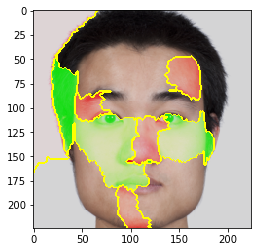

In [259]:
get_lime_woman("../../MR2 faces/am04.tif")

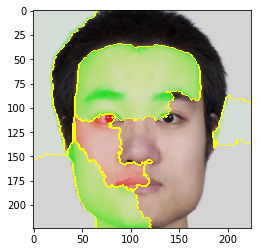

In [261]:
get_lime_man("../../MR2 faces/am04.tif")

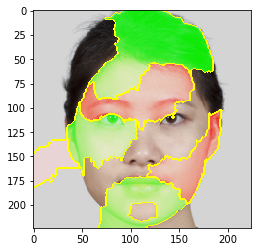

In [257]:
get_lime_woman("../../MR2 faces/af12.tif")

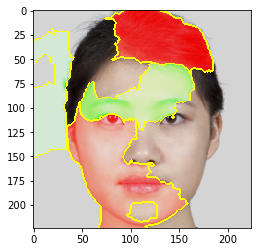

In [260]:
get_lime_man("../../MR2 faces/af12.tif")

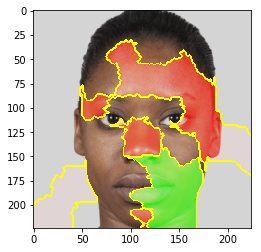

In [258]:
get_lime_woman("../../MR2 faces/bf17.tif")

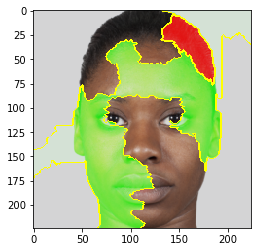

In [262]:
get_lime_man("../../MR2 faces/bf17.tif")